# Autoencoder for face images

In this notebook we study autoencoders for face images. We use the [Olivetti dataset](https://www.kaggle.com/datasets/imrandude/olivetti) dataset, which contains 400 64x64 grayscale images from 40 people. We experiment with autoencoders for face representation, face generation, and face reconstruction from missing pixels/blocks. Note that the dataset being relatively small, results are limited. But this can give some idea on how to use autoencoders for face representation/reconstruction.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn import functional as F
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display

import utils
import utils.data, utils.ML, utils.models

In [2]:
plt.rcParams['image.cmap'] = 'gray'  # default colormap

# Data preparation/visualization

In [3]:
data = np.load(utils.data.DATA_ROOT + '/olivetti_faces/olivetti_faces.npy')
labels = np.load(utils.data.DATA_ROOT + '/olivetti_faces/olivetti_faces_target.npy')

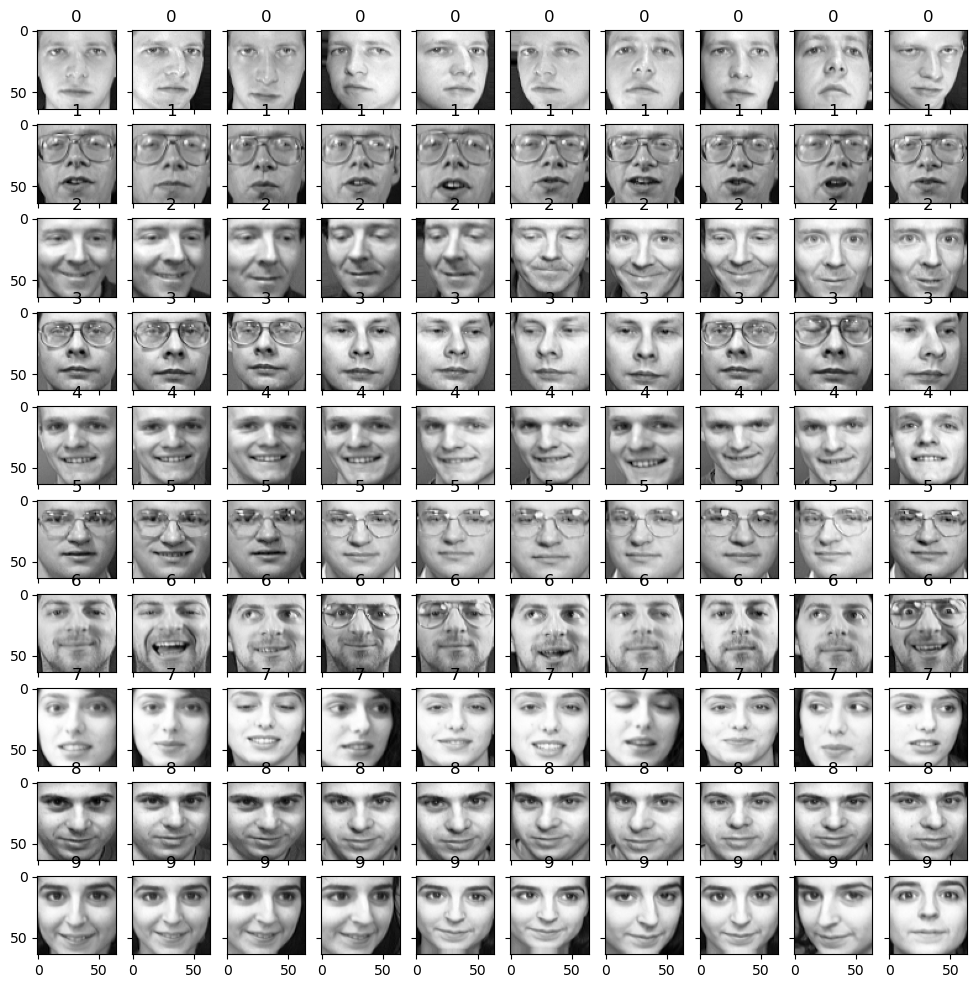

In [4]:
# Visualize dataset:

fig, ax = plt.subplots(10, 10, figsize=(12,12), sharex=True, sharey=True)
ax = ax.flatten()

for i in range(100):
    ax[i].imshow(data[i])
    ax[i].set_title(str(labels[i]))

In [5]:
# Prepare data:

# 350 images for training, 50 for testing, no same person in train/test sets

data_train, data_test = torch.Tensor(data[:350, np.newaxis, :, :]), torch.Tensor(data[350:, np.newaxis, :, :])
label_train, label_test = torch.Tensor(labels[:350]), torch.Tensor(labels[350:])

# Normalize data:

normalize = True

if normalize:
    mu = torch.mean(data_train)
    sigma = torch.sqrt(torch.mean((data_train-mu)**2))
else:
    mu, sigma = 0.0, 1.0
    
def normalize_func(X):
    return (X-mu)/sigma

def denormalize_func(X_):
    return X_*sigma + mu
    
data_train = (data_train-mu)/sigma
data_test = (data_test-mu)/sigma

# create pytorch dataset:
train_dataset = TensorDataset(data_train, label_train)
test_dataset = TensorDataset(data_test, label_test)

# data loaders:
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [6]:
device = "mps"
loss_fn = nn.MSELoss()

# Define autoencoder:

In [7]:
class CNN_autoencoder(nn.Module):
    
    def __init__(self, latent_dim):
        super().__init__()
                
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 32x64x64
                                    nn.ReLU(),
                                    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 64x32x32
                                    nn.ReLU(),
                                    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 128x16x16
                                    nn.ReLU(),
                                    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 256x8x8
                                    nn.ReLU(),
                                    nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 512x4x4
                                    nn.ReLU(),
                                    nn.Conv2d(512, 1024, kernel_size=4, stride=1, padding=0), # 1024x1x1
                                    nn.ReLU(),
                                    nn.Conv2d(1024, latent_dim, kernel_size=1, stride=1)  # 1x1 convolution
                                    )
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(latent_dim, 1024, kernel_size=1, stride=1),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x4x4
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),  
                                    nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = (x-mu)/sigma  # scale output data 
        return x

# Experiment 1: face image representation (compression)

In [8]:
latent_dim = 1024  # dimension of latent (encoded) space
model = CNN_autoencoder(latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
num_epochs = 30

 epoch:  1, training loss: 1.648, validation loss: 1.181, validation SNR: 9.375
 epoch:  2, training loss: 1.351, validation loss: 1.207, validation SNR: 9.280
 epoch:  3, training loss: 1.086, validation loss: 0.854, validation SNR: 10.779
 epoch:  4, training loss: 0.681, validation loss: 0.780, validation SNR: 11.172
 epoch:  5, training loss: 0.641, validation loss: 0.765, validation SNR: 11.259
 epoch:  6, training loss: 0.613, validation loss: 0.724, validation SNR: 11.496
 epoch:  7, training loss: 0.589, validation loss: 0.706, validation SNR: 11.607
 epoch:  8, training loss: 0.572, validation loss: 0.678, validation SNR: 11.781
 epoch:  9, training loss: 0.549, validation loss: 0.650, validation SNR: 11.968
 epoch: 10, training loss: 0.506, validation loss: 0.607, validation SNR: 12.265
 epoch: 11, training loss: 0.480, validation loss: 0.570, validation SNR: 12.536
 epoch: 12, training loss: 0.454, validation loss: 0.526, validation SNR: 12.883
 epoch: 13, training loss: 0.4

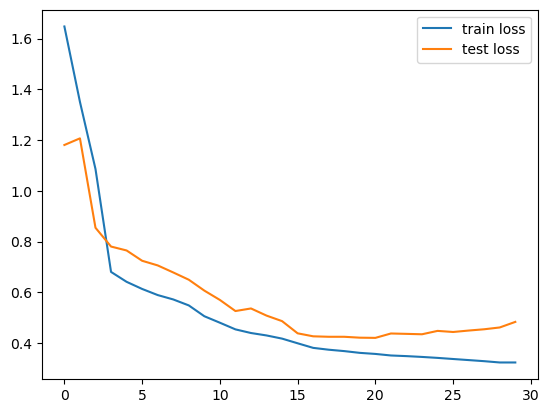

In [9]:
train_loss_log, test_loss_log = utils.ML.train_autoencoder(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, denormalize_func, device, verbose=True)
# Note: no validation set here since the dataset is too small, we "validate" (i.e. evaluate) on the test set directly

plt.figure()
plt.plot(train_loss_log)
plt.plot(test_loss_log)
plt.legend(["train loss", "test loss"])

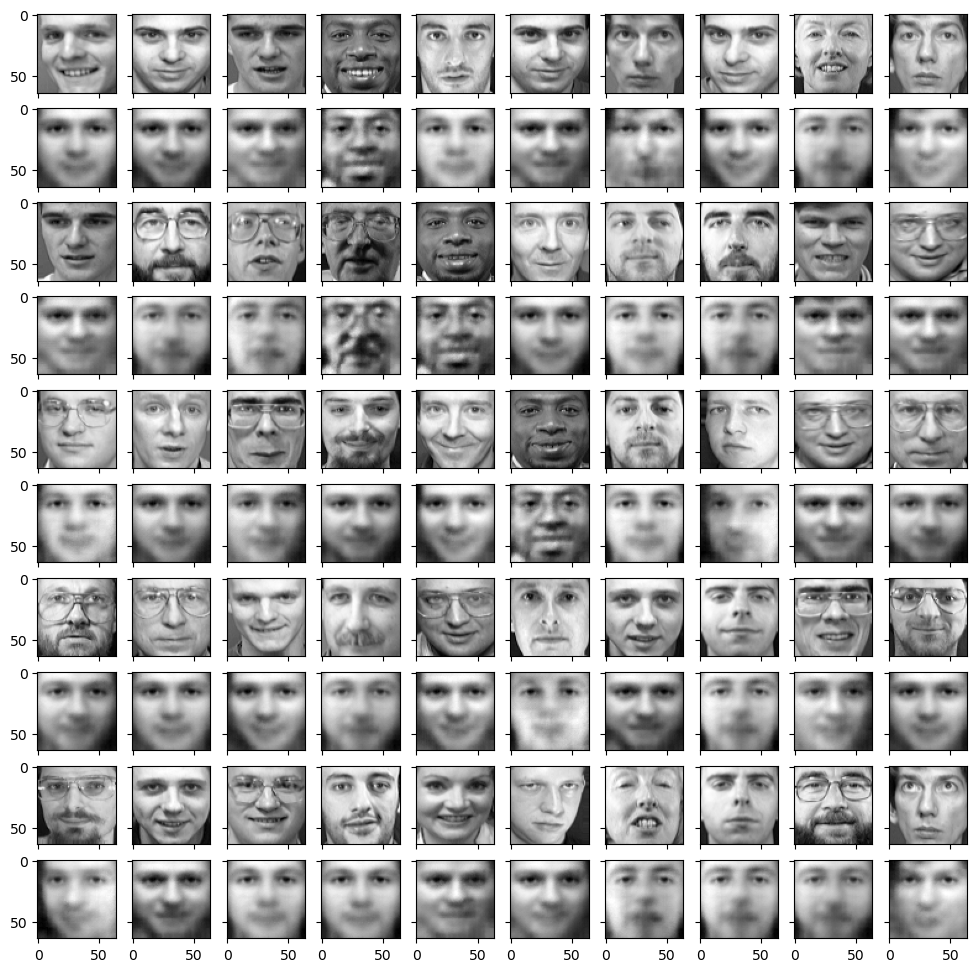

In [10]:
# Visualize a few examples on ther training set:

X, _ = next(iter(train_dataloader))

Y = model(X.to(device)).detach().cpu()

fig, ax = plt.subplots(10, 10, figsize=(12,12), sharex=True, sharey=True)
# ax = ax.flatten()

for i in range(50):
    ax[2*(i//10), i%10].imshow(torch.squeeze(X[i]))
    ax[2*(i//10)+1, i%10].imshow(torch.squeeze(Y[i]))

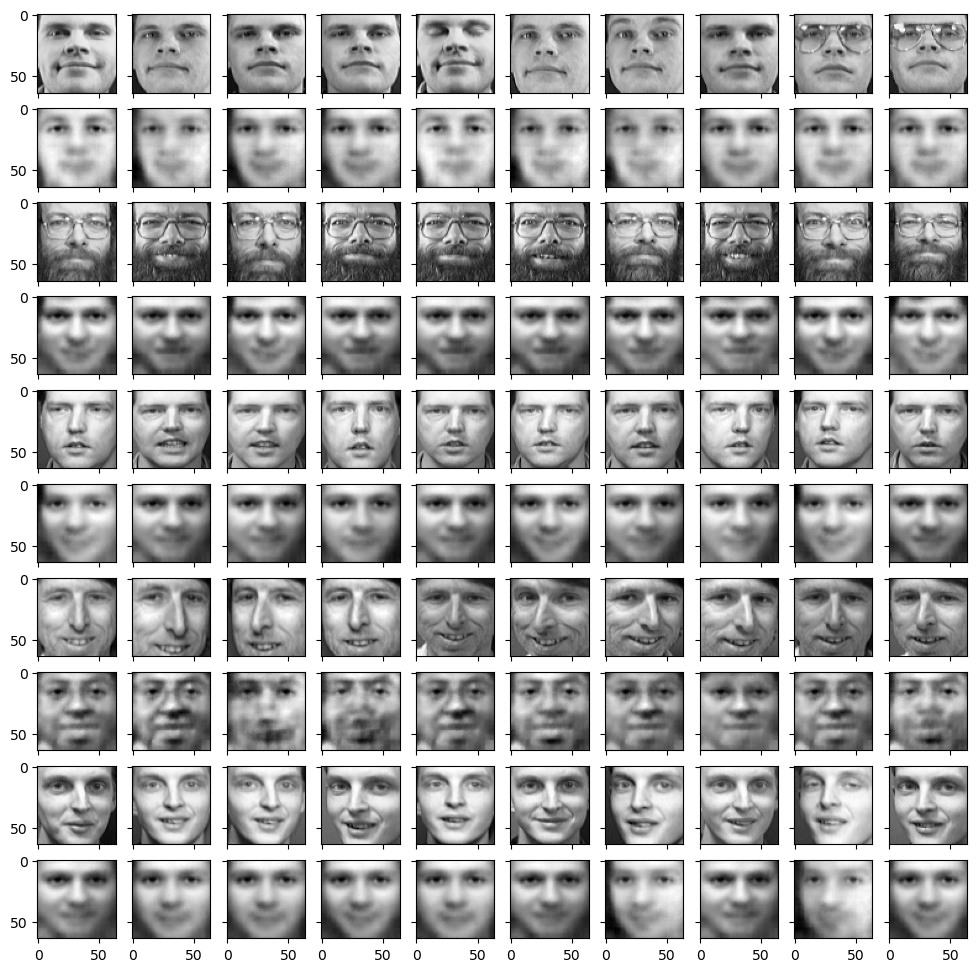

In [11]:
# Visualize a few examples on ther test set:

X, _ = next(iter(test_dataloader))

Y = model(X.to(device)).detach().cpu()

fig, ax = plt.subplots(10, 10, figsize=(12,12), sharex=True, sharey=True)
# ax = ax.flatten()

for i in range(50):
    ax[2*(i//10), i%10].imshow(torch.squeeze(X[i]))
    ax[2*(i//10)+1, i%10].imshow(torch.squeeze(Y[i]))

In [12]:
# save trained model for later use:
import copy
trained_autoencoder_1024 = copy.copy(model)

# Experiment 2: face image generation

Here he train an autoencoder with a 2-dimensional latent space, and visualize images sampled from that 2-dimensional space.

In [13]:
latent_dim = 2
model = CNN_autoencoder(latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
num_epochs = 30

 epoch:  1, training loss: 0.998, validation loss: 1.051, validation SNR: 9.882
 epoch:  2, training loss: 0.825, validation loss: 0.833, validation SNR: 10.888
 epoch:  3, training loss: 0.640, validation loss: 0.713, validation SNR: 11.565
 epoch:  4, training loss: 0.576, validation loss: 0.679, validation SNR: 11.776
 epoch:  5, training loss: 0.567, validation loss: 0.624, validation SNR: 12.144
 epoch:  6, training loss: 0.536, validation loss: 0.603, validation SNR: 12.294
 epoch:  7, training loss: 0.491, validation loss: 0.549, validation SNR: 12.702
 epoch:  8, training loss: 0.458, validation loss: 0.532, validation SNR: 12.836
 epoch:  9, training loss: 0.442, validation loss: 0.532, validation SNR: 12.835
 epoch: 10, training loss: 0.432, validation loss: 0.513, validation SNR: 12.994
 epoch: 11, training loss: 0.422, validation loss: 0.502, validation SNR: 13.092
 epoch: 12, training loss: 0.415, validation loss: 0.493, validation SNR: 13.166
 epoch: 13, training loss: 0.

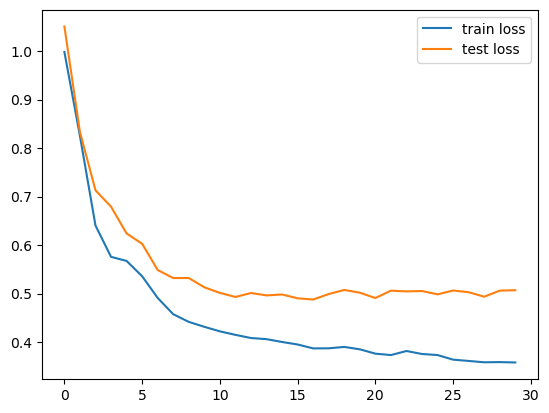

In [14]:
train_loss_log, test_loss_log = utils.ML.train_autoencoder(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, denormalize_func, device, verbose=True)
# Note: no validation set here since the dataset is too small, we "validate" on the test set directly

plt.figure()
plt.plot(train_loss_log)
plt.plot(test_loss_log)
plt.legend(["train loss", "test loss"])

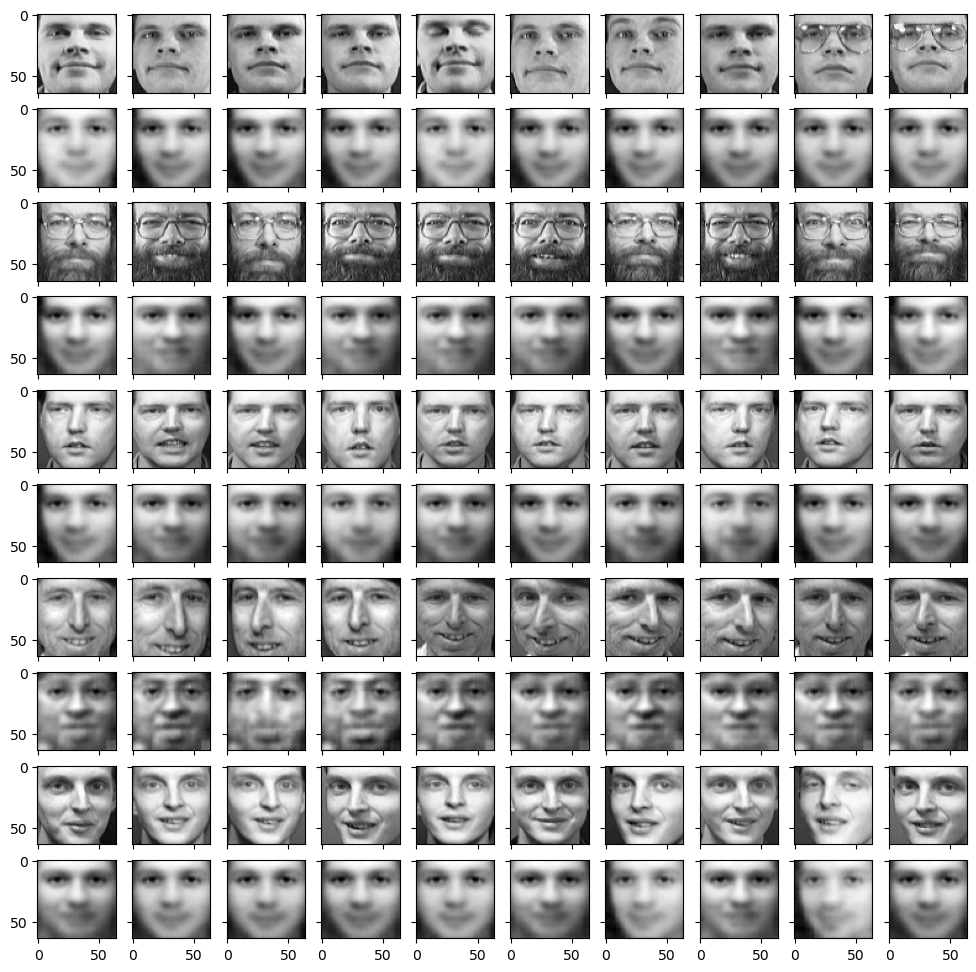

In [15]:
# Visualize a few examples:

# X, _ = next(iter(train_dataloader))
X, _ = next(iter(test_dataloader))

Y = model(X.to(device)).detach().cpu()

fig, ax = plt.subplots(10, 10, figsize=(12,12), sharex=True, sharey=True)
# ax = ax.flatten()

for i in range(50):
    ax[2*(i//10), i%10].imshow(torch.squeeze(X[i]))
    ax[2*(i//10)+1, i%10].imshow(torch.squeeze(Y[i]))

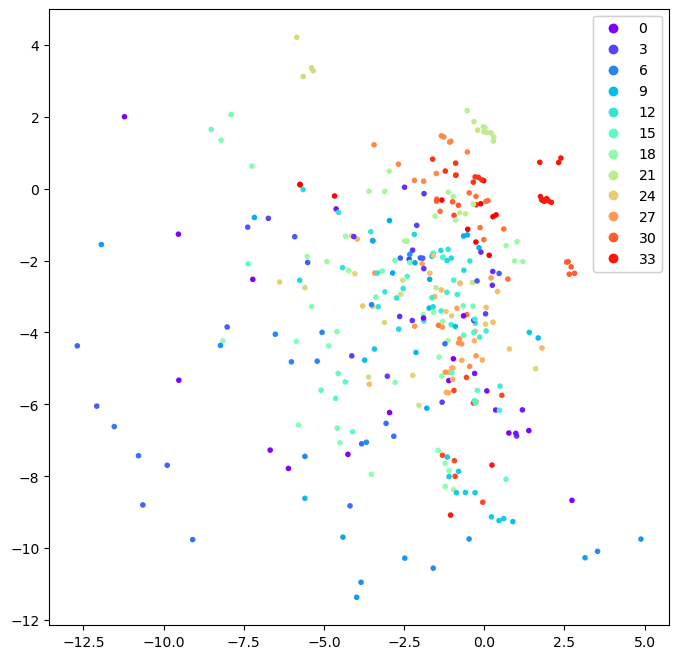

In [16]:
# Scatterplot of encoded training set:

fig, ax = plt.subplots(figsize=(8, 8))

for X, y in train_dataloader:
    
    Z = model.encoder(X.to(device))
    Z = Z[..., 0, 0].detach().cpu()
            
    scatter = ax.scatter(Z[:, 0], Z[:, 1], c=y, cmap="rainbow", marker=".")
                
    legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)

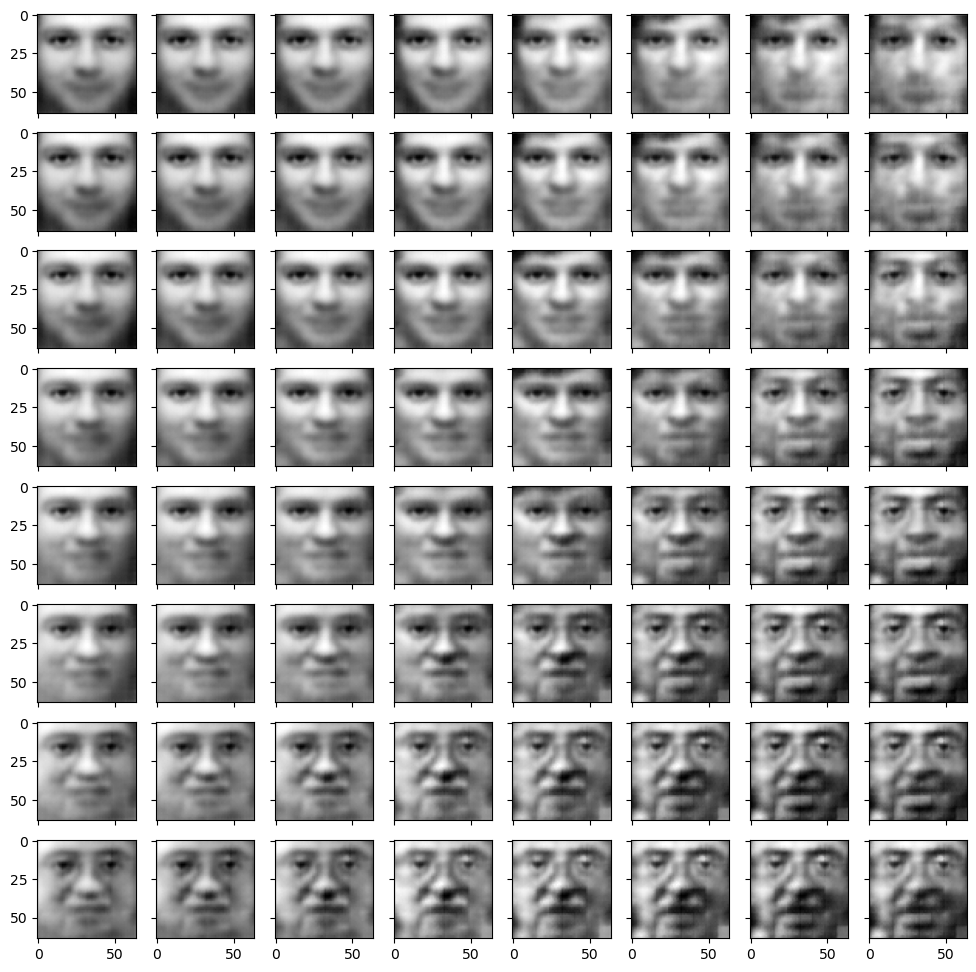

In [17]:
# Sample images from 2d latent (encoded) space:

fig, ax = plt.subplots(8, 8, sharex=True, sharey=True, figsize=(12, 12))

x_range = np.linspace(-2, 2, 8)
y_range = np.linspace(-2, 2, 8)

for i in range(8):
    for j in range(8):
        x_code = torch.zeros((1, latent_dim, 1, 1))
        x_code[0,0,0,0] = x_range[i]
        x_code[0,1,0,0] = y_range[j]
        x_code = x_code.to(device)
        out = model.decoder(x_code)
        out_im = out[0,0].detach().cpu()
        ax[i, j].imshow(out_im)

# Experiment 3: face reconstruction

Here we experiment with face reconstruction from missing pixels/occlusion. We simply use the autoencoder that was trained on clean images in section 1. Note that training with noisy images could improve the results. A larger dataset could also lead to better results.

In [18]:
# Use model pre-trained on clean images:
model = trained_autoencoder_1024

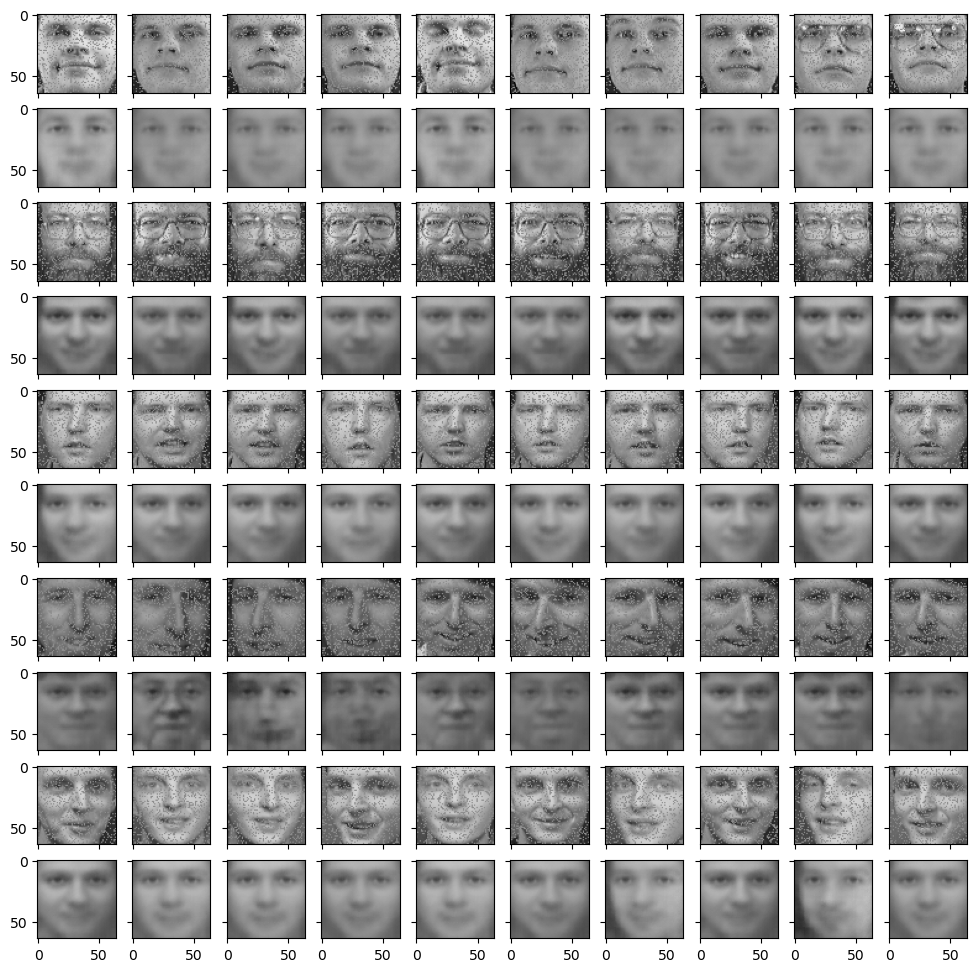

In [21]:
# Reconstruct images with pixels missing at random:

# X, _ = next(iter(train_dataloader))
X, _ = next(iter(test_dataloader))

missing_percent = 0.2
mask = torch.rand_like(X) > missing_percent

# X = normalize_func(denormalize_func(X) * mask)
X = X * mask

Y = model(X.to(device)).detach().cpu()

fig, ax = plt.subplots(10, 10, figsize=(12,12), sharex=True, sharey=True)
# ax = ax.flatten()

for i in range(50):
    ax[2*(i//10), i%10].imshow(denormalize_func(torch.squeeze(X[i])), vmin=0, vmax=1)
    ax[2*(i//10)+1, i%10].imshow(denormalize_func(torch.squeeze(Y[i])), vmin=0, vmax=1)

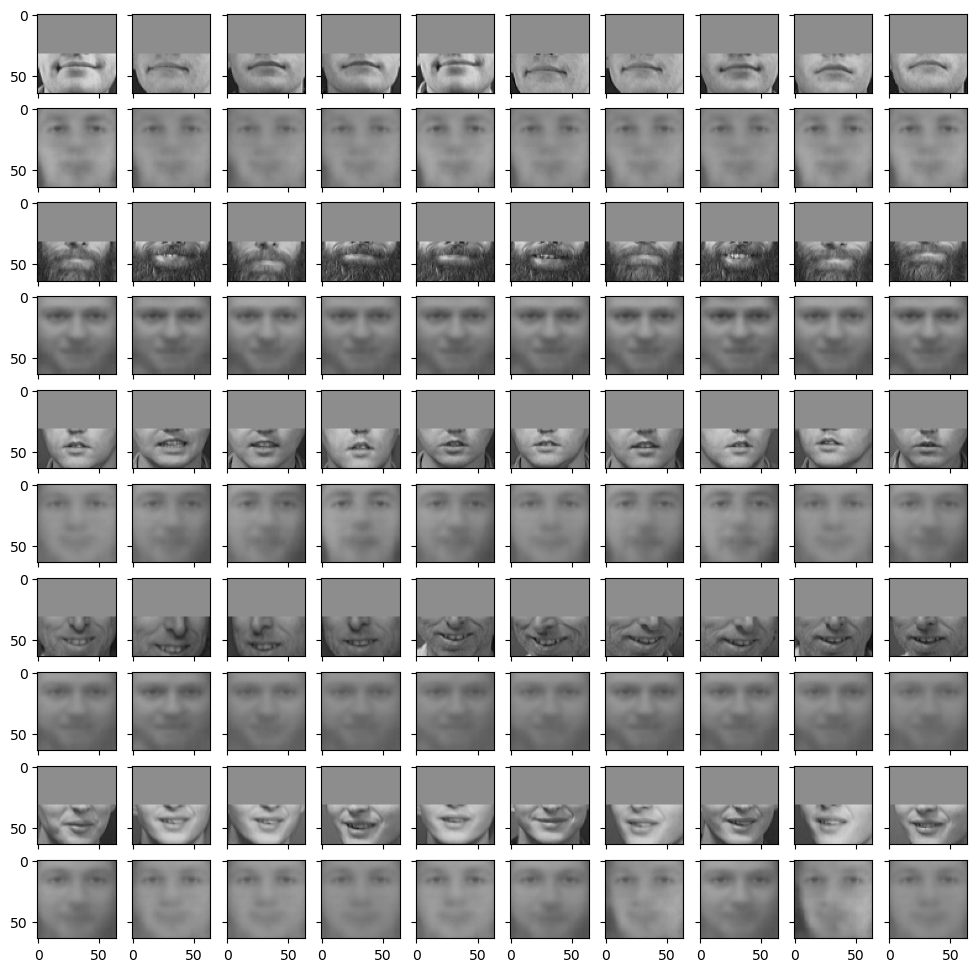

In [22]:
# Reconstruct images top half pixels missing:

# X, _ = next(iter(train_dataloader))
X, _ = next(iter(test_dataloader))

mask = torch.ones_like(X)
mask[:,:,:32,:] = 0.0

# X = normalize_func(denormalize_func(X) * mask)
X = X * mask

Y = model(X.to(device)).detach().cpu()

fig, ax = plt.subplots(10, 10, figsize=(12,12), sharex=True, sharey=True)
# ax = ax.flatten()

for i in range(50):
    ax[2*(i//10), i%10].imshow(denormalize_func(torch.squeeze(X[i])), vmin=0, vmax=1)
    ax[2*(i//10)+1, i%10].imshow(denormalize_func(torch.squeeze(Y[i])), vmin=0, vmax=1)